# Import libraries

In [2]:
import numpy as np
import pandas as pd
import gtda
import matplotlib.pyplot as plt
import seaborn as sns

from gtda.time_series import SingleTakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_point_cloud
from sklearn.neighbors import KernelDensity

# Import data

In [3]:
train = pd.read_csv('/Users/davepipon/Desktop/Dataset/sales_train_evaluation.csv')
test = pd.read_csv('/Users/davepipon/Desktop/Dataset/sales_test_evaluation.csv')
df = pd.merge(train, test, on=["item_id", "store_id", "dept_id", "cat_id", "state_id"], how="inner")

print(df.shape)
df = df.iloc[:,:510] # Training example

print(df.shape)
df.head()


(30490, 1974)
(30490, 510)


,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,...,d_496,d_497,d_498,d_499,d_500,d_501,d_502,d_503,d_504,d_505
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,2,0,5,1,0,1,1,2,1
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,2,2,2,5,2,1,1,2,2


# Preprocessing

In [4]:
# Create a new column for the Intermittency and Group variable
temp = df.iloc[:, 5:].copy()
temp['Intermittency'] = (temp == 0).sum(axis=1) / temp.shape[1]
temp['Group'] = temp['Intermittency'].apply(lambda x: 'High' if x >= 0.81 else ('Low' if x < 0.51 else 'Medium'))

df['Intermittency'] = temp['Intermittency']
df['Group'] = temp['Group']

df = df[df['Intermittency'] < 1]

df.head()

,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,...,d_498,d_499,d_500,d_501,d_502,d_503,d_504,d_505,Intermittency,Group
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0.847525,High
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,5,1,0,1,1,2,1,0.390099,Low
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,2,2,5,2,1,1,2,2,0.699010,Medium
5,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,2,0,0,0,0,2,0,0,0.912871,High
7,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,12,15,0,0,0,...,0,13,3,5,31,20,3,1,0.324752,Low


In [5]:
# Split the DataFrame into three groups based on Intermittency
df_high = df[df['Group'] == 'High']
df_mod = df[df['Group'] == 'Medium']
df_low = df[df['Group'] == 'Low']

df_high = df_high.drop(columns=['Group', 'item_id', 'store_id', 'dept_id', 'cat_id', 'state_id']).to_numpy()
df_mod = df_mod.drop(columns=['Group', 'item_id', 'store_id', 'dept_id', 'cat_id', 'state_id']).to_numpy()
df_low = df_low.drop(columns=['Group', 'item_id', 'store_id', 'dept_id', 'cat_id', 'state_id']).to_numpy()

print(df_high.shape, df_mod.shape, df_low.shape)

(6586, 506) (6886, 506) (6220, 506)


# Highly intermittent (Intermittency >= 0.81)

In [6]:
# Embedding dimension and time-delay
delta = 3 
tau = 7

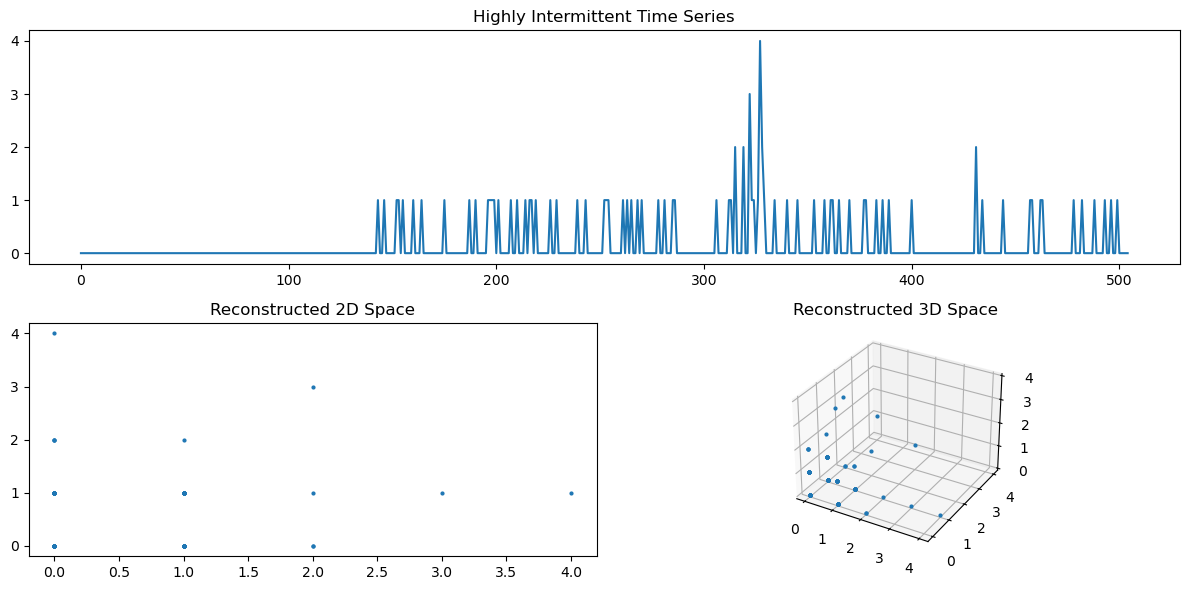

In [7]:
x = df_high[0, :-1]
t = np.linspace(0, len(x)-1, len(x))

# Reconstruct time-delay vector
V = np.array([x[:-2*tau], x[tau:-tau], x[2*tau:]])
# Original data
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(t, x)
plt.title('Highly Intermittent Time Series')
# After reconstruct
plt.subplot(223)
plt.plot(V[0], V[1], marker='o', markersize=2, linestyle='None')
plt.title('Reconstructed 2D Space')
plt.tight_layout()

plt.subplot(224, projection='3d')
plt.plot(V[0], V[1], V[2], marker='o', markersize=2, linestyle='None')
plt.title('Reconstructed 3D Space')
plt.tight_layout()
plt.show()

## Example persistence plot

In [8]:
embedder_nonperiodic = SingleTakensEmbedding(
    parameters_type = "fixed",
    time_delay = 7,
    dimension = 2
)

y_nonperiodic_embedded = embedder_nonperiodic.fit_transform(x)
y_nonperiodic_embedded = y_nonperiodic_embedded[None, :, :]

nonperiodic_persistence = VietorisRipsPersistence(
    homology_dimensions = [0, 1]
)
nonperiodic_persistence.fit_transform_plot(y_nonperiodic_embedded)

array([[[0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.41421354, 0.        ],
        [0.        , 2.        , 0.        ],
        [1.        , 1.41421354, 1.        ],
        [1.        , 1.41421354, 1.        ],
        [1.        , 1.41421354, 1.        ]]])

In [9]:
# Initialize an empty DataFrame to store results
high_fit_df = pd.DataFrame()

# Add an 'Intermittency' column to the DataFrame
high_fit_df['Intermittency'] = pd.Series(dtype=float)
high_fit_df['ID'] = pd.Series(dtype=int)

# Loop on all high intermittent time series
for i in range(df_high.shape[0]):
    x = df_high[i, :-1]
    t = np.linspace(0, len(x)-1, len(x))
    
    y_nonperiodic_embedded = embedder_nonperiodic.fit_transform(x)
    y_nonperiodic_embedded = y_nonperiodic_embedded[None, :, :]

    nonperiodic_persistence = VietorisRipsPersistence(
        homology_dimensions = [0, 1]
    )
    
    persistence_result = nonperiodic_persistence.fit_transform(y_nonperiodic_embedded)  
    persistence_df = pd.DataFrame(persistence_result[0], columns=["birth", "death", "dimension"])
    persistence_df['Intermittency'] = df_high[i, -1]  # Add 'Intermittency' column to persistence_df
    persistence_df['ID'] = i  # Add 'ID' column to persistence_df
    high_fit_df = pd.concat([high_fit_df, persistence_df], ignore_index=True)

high_fit_df.head()

,Intermittency,ID,birth,death,dimension
0,0.847525,0,0.0,1.0,0.0
1,0.847525,0,0.0,1.0,0.0
2,0.847525,0,0.0,1.0,0.0
3,0.847525,0,0.0,1.0,0.0
4,0.847525,0,0.0,1.0,0.0


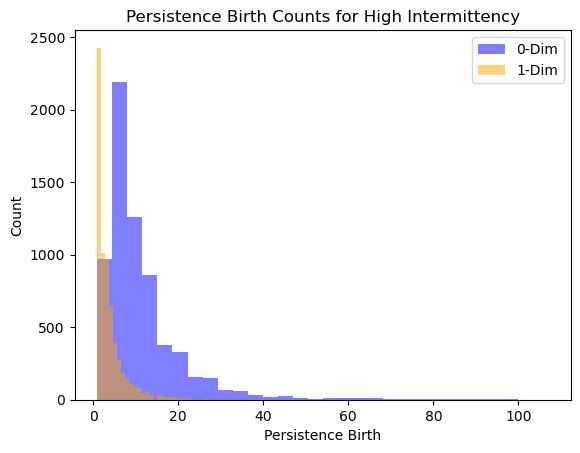

In [10]:
# Aggregate 0 and 1 dim per ID
agg_df_high = pd.pivot_table(high_fit_df,
                        index=['ID', 'Intermittency'],
                        columns='dimension',
                        values='birth',
                        aggfunc='count').reset_index()

agg_df_high.head()
plt.hist(agg_df_high[0], bins=30, alpha=0.5, label='0-Dim', color='blue')
plt.hist(agg_df_high[1], bins=30, alpha=0.5, label='1-Dim', color='orange')
plt.legend()
plt.xlabel('Persistence Birth')
plt.ylabel('Count')
plt.title('Persistence Birth Counts for High Intermittency')
plt.show()

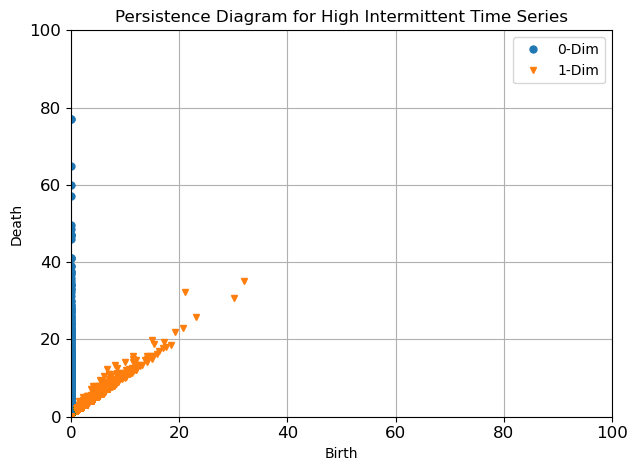

In [11]:
plt.plot(high_fit_df[high_fit_df['dimension'] == 0]['birth'],
         high_fit_df[high_fit_df['dimension'] == 0]['death'], 
         marker='o', markersize=5, linestyle='None')
plt.plot(high_fit_df[high_fit_df['dimension'] == 1]['birth'],
         high_fit_df[high_fit_df['dimension'] == 1]['death'], 
         marker='v', markersize=5, linestyle='None')
plt.title('Persistence Diagram for High Intermittent Time Series')
plt.xlabel('Birth')
plt.ylabel('Death')
plt.xlim(0, 100)
plt.ylim(0, 100)
legend = plt.legend(['0-Dim', '1-Dim'], loc='upper right')
plt.tight_layout()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()

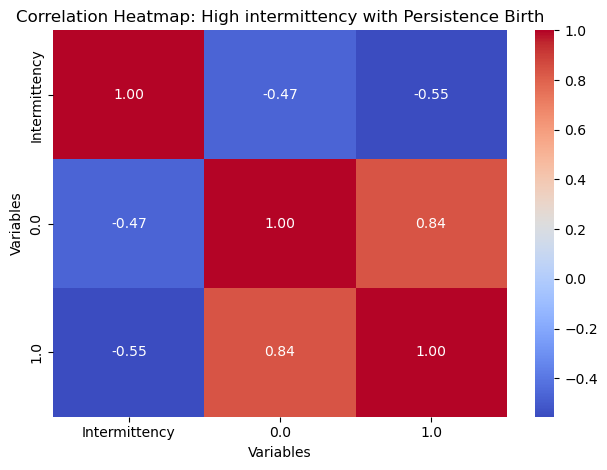

In [12]:
# Correlate intermittency with persistence birth
corr = agg_df_high[['Intermittency', 0, 1]].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap: High intermittency with Persistence Birth')
plt.tight_layout()
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.show()

# Moderately intermittent (Intermittency < 0.81 & >= 0.0.51)

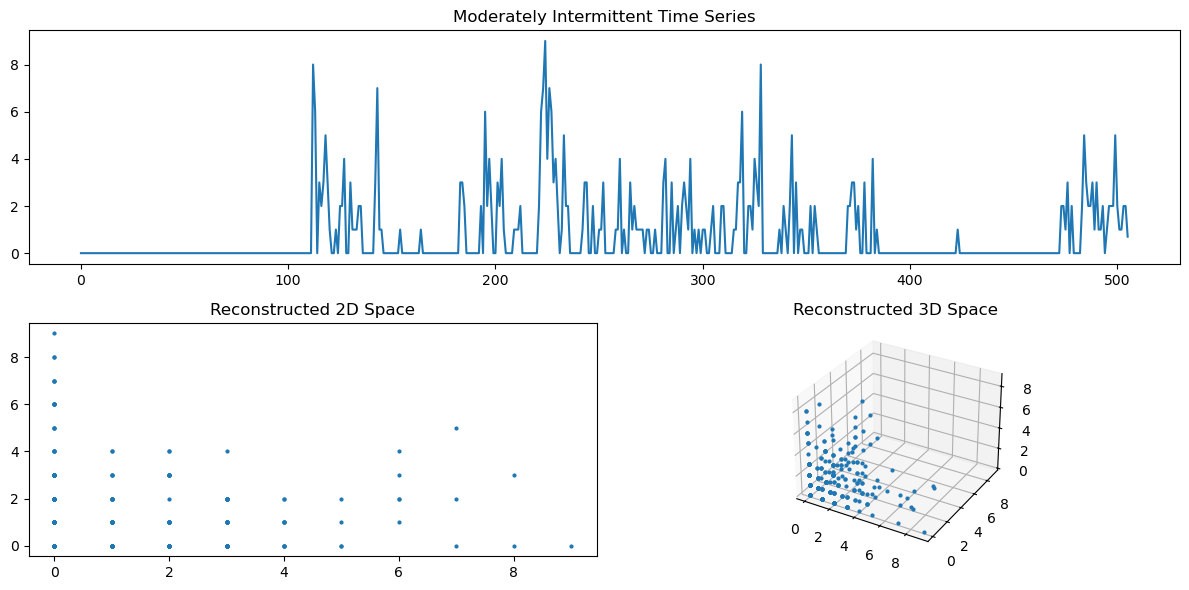

In [13]:
x = df_mod[0, :]
t = np.linspace(0, len(x)-1, len(x))

# Reconstruct time-delay vector
V = np.array([x[:-2*tau], x[tau:-tau], x[2*tau:]])
# Original data
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(t, x)
plt.title('Moderately Intermittent Time Series')
# After reconstruct
plt.subplot(223)
plt.plot(V[0], V[1], marker='o', markersize=2, linestyle='None')
plt.title('Reconstructed 2D Space')
plt.tight_layout()

plt.subplot(224, projection='3d')
plt.plot(V[0], V[1], V[2], marker='o', markersize=2, linestyle='None')
plt.title('Reconstructed 3D Space')
plt.tight_layout()
plt.show()

## Example persistence plot

In [14]:
embedder_nonperiodic = SingleTakensEmbedding(
    parameters_type = "fixed",
    time_delay = 7,
    dimension = 2,
)

y_nonperiodic_embedded = embedder_nonperiodic.fit_transform(x)

y_nonperiodic_embedded = y_nonperiodic_embedded[None, :, :]

nonperiodic_persistence = VietorisRipsPersistence(
    homology_dimensions = [0, 1]
)
nonperiodic_persistence.fit_transform_plot(y_nonperiodic_embedded)

array([[[0.        , 0.3009901 , 0.        ],
        [0.        , 0.6990099 , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0

In [15]:
# Initialize an empty DataFrame to store results
mod_fit_df = pd.DataFrame()

# Add an 'Intermittency' column to the DataFrame
mod_fit_df['Intermittency'] = pd.Series(dtype=float)
mod_fit_df['ID'] = pd.Series(dtype=int)

# Loop on all high intermittent time series
for i in range(df_mod.shape[0]):
    x = df_mod[i, :-1]
    t = np.linspace(0, len(x)-1, len(x))
    
    y_nonperiodic_embedded = embedder_nonperiodic.fit_transform(x)
    y_nonperiodic_embedded = y_nonperiodic_embedded[None, :, :]

    nonperiodic_persistence = VietorisRipsPersistence(
        homology_dimensions = [0, 1]
    )
    
    persistence_result = nonperiodic_persistence.fit_transform(y_nonperiodic_embedded)
    persistence_df = pd.DataFrame(persistence_result[0], columns=["birth", "death", "dimension"])
    persistence_df['Intermittency'] = df_mod[i, -1]  # Add 'Intermittency' column to persistence_df
    persistence_df['ID'] = i  # Add 'ID' column to persistence_df
    mod_fit_df = pd.concat([mod_fit_df, persistence_df], ignore_index=True)

mod_fit_df.head()

,Intermittency,ID,birth,death,dimension
0,0.69901,0,0.0,1.0,0.0
1,0.69901,0,0.0,1.0,0.0
2,0.69901,0,0.0,1.0,0.0
3,0.69901,0,0.0,1.0,0.0
4,0.69901,0,0.0,1.0,0.0


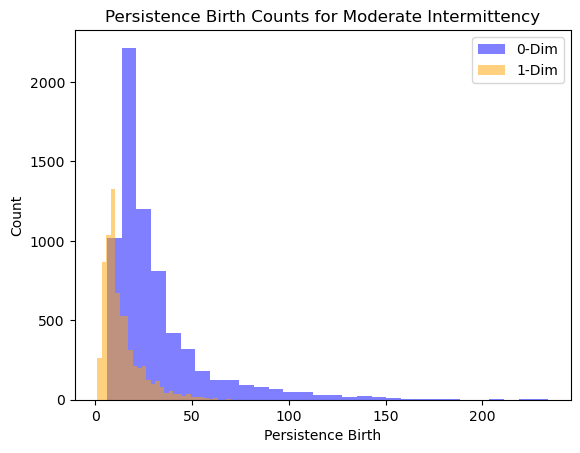

In [16]:
# Aggregate 0 and 1 dim per ID
agg_df_mod = pd.pivot_table(mod_fit_df,
                        index=['ID', 'Intermittency'],
                        columns='dimension',
                        values='birth',
                        aggfunc='count').reset_index()

agg_df_high.head()
plt.hist(agg_df_mod[0], bins=30, alpha=0.5, label='0-Dim', color='blue')
plt.hist(agg_df_mod[1], bins=30, alpha=0.5, label='1-Dim', color='orange')
plt.legend()
plt.xlabel('Persistence Birth')
plt.ylabel('Count')
plt.title('Persistence Birth Counts for Moderate Intermittency')
plt.show()

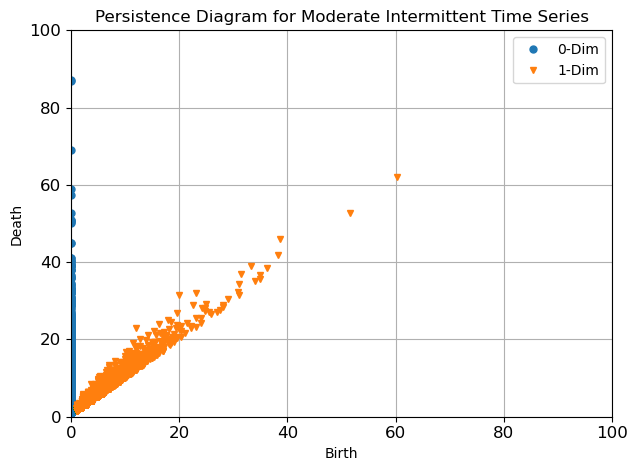

In [17]:
plt.plot(mod_fit_df[mod_fit_df['dimension'] == 0]['birth'],
         mod_fit_df[mod_fit_df['dimension'] == 0]['death'], 
         marker='o', markersize=5, linestyle='None')
plt.plot(mod_fit_df[mod_fit_df['dimension'] == 1]['birth'],
         mod_fit_df[mod_fit_df['dimension'] == 1]['death'], 
         marker='v', markersize=5, linestyle='None')
plt.title('Persistence Diagram for Moderate Intermittent Time Series')
plt.xlabel('Birth')
plt.ylabel('Death')
plt.xlim(0, 100)
plt.ylim(0, 100)
legend = plt.legend(['0-Dim', '1-Dim'], loc='upper right')
plt.tight_layout()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()

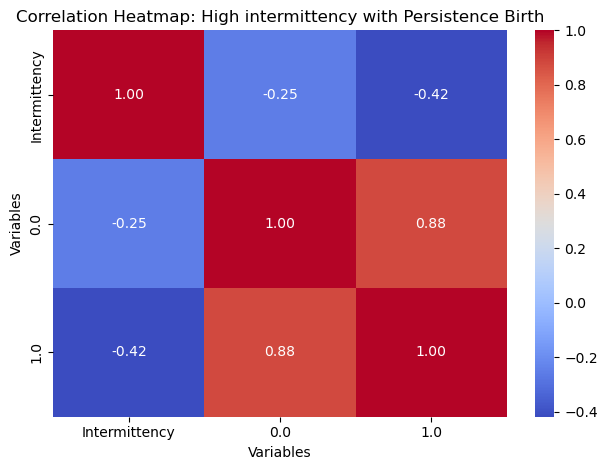

In [18]:
# Correlate intermittency with persistence birth
corr = agg_df_mod[['Intermittency', 0, 1]].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap: High intermittency with Persistence Birth')
plt.tight_layout()
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.show()

# Low intermittent (Intermittency < 0.51)

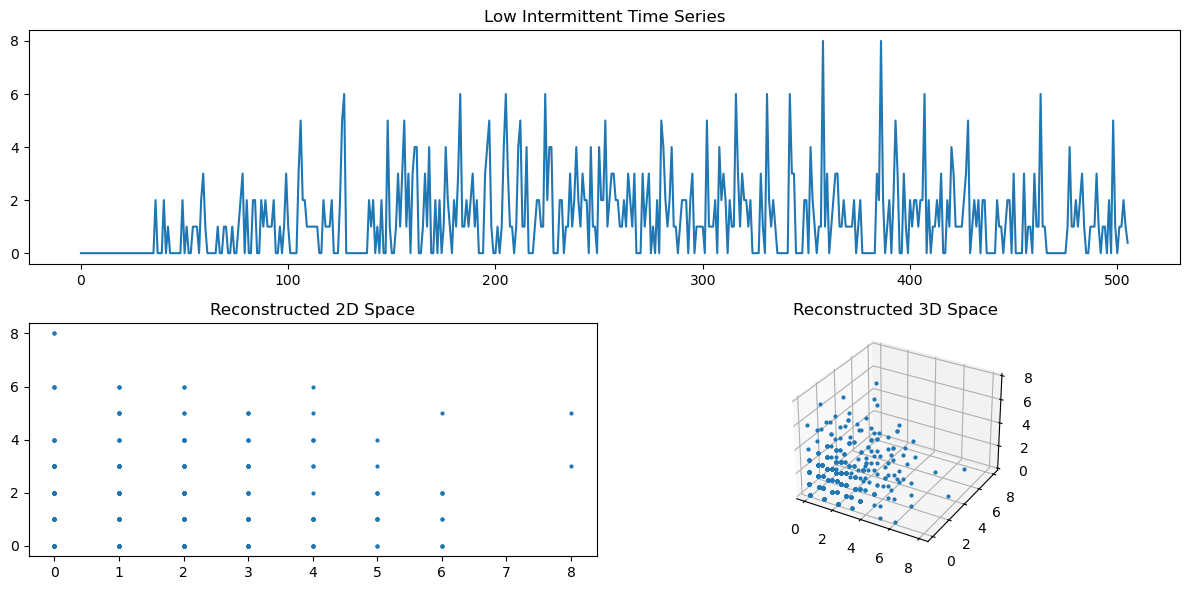

In [19]:
x = df_low[0, :]
t = np.linspace(0, len(x)-1, len(x))

# Reconstruct time-delay vector
V = np.array([x[:-2*tau], x[tau:-tau], x[2*tau:]])
# Original data
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(t, x)
plt.title('Low Intermittent Time Series')
# After reconstruct
plt.subplot(223)
plt.plot(V[0], V[1], marker='o', markersize=2, linestyle='None')
plt.title('Reconstructed 2D Space')
plt.tight_layout()

plt.subplot(224, projection='3d')
plt.plot(V[0], V[1], V[2], marker='o', markersize=2, linestyle='None')
plt.title('Reconstructed 3D Space')
plt.tight_layout()
plt.show()

## Example persistence plot

In [20]:
embedder_nonperiodic = SingleTakensEmbedding(
    parameters_type = "fixed",
    time_delay = 7,
    dimension = 2
)

y_nonperiodic_embedded = embedder_nonperiodic.fit_transform(x)

y_nonperiodic_embedded = y_nonperiodic_embedded[None, :, :]

nonperiodic_persistence = VietorisRipsPersistence(
    homology_dimensions = [0, 1]
)
nonperiodic_persistence.fit_transform_plot(y_nonperiodic_embedded)

array([[[0.        , 0.39009902, 0.        ],
        [0.        , 0.60990101, 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0

In [21]:
# Initialize an empty DataFrame to store results
low_fit_df = pd.DataFrame()

# Add an 'Intermittency' column to the DataFrame
low_fit_df['Intermittency'] = pd.Series(dtype=float)
low_fit_df['ID'] = pd.Series(dtype=int)

# Loop on all high intermittent time series
for i in range(df_low.shape[0]):
    x = df_low[i, :-1]
    t = np.linspace(0, len(x)-1, len(x))
    
    y_nonperiodic_embedded = embedder_nonperiodic.fit_transform(x)
    y_nonperiodic_embedded = y_nonperiodic_embedded[None, :, :]

    nonperiodic_persistence = VietorisRipsPersistence(
        homology_dimensions = [0, 1]
    )
    
    persistence_result = nonperiodic_persistence.fit_transform(y_nonperiodic_embedded)
    persistence_df = pd.DataFrame(persistence_result[0], columns=["birth", "death", "dimension"])
    persistence_df['Intermittency'] = df_low[i, -1]  # Add 'Intermittency' column to persistence_df
    persistence_df['ID'] = i  # Add 'ID' column to persistence_df
    low_fit_df = pd.concat([low_fit_df, persistence_df], ignore_index=True)

low_fit_df.head()

,Intermittency,ID,birth,death,dimension
0,0.390099,0,0.0,1.0,0.0
1,0.390099,0,0.0,1.0,0.0
2,0.390099,0,0.0,1.0,0.0
3,0.390099,0,0.0,1.0,0.0
4,0.390099,0,0.0,1.0,0.0


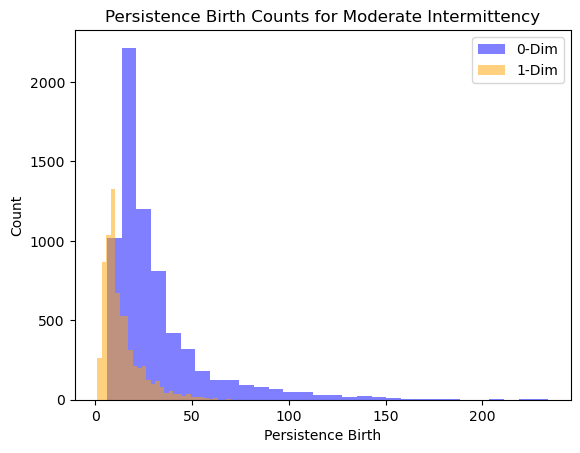

In [22]:
# Aggregate 0 and 1 dim per ID
agg_df_low = pd.pivot_table(low_fit_df,
                        index=['ID', 'Intermittency'],
                        columns='dimension',
                        values='birth',
                        aggfunc='count').reset_index()

agg_df_high.head()
plt.hist(agg_df_mod[0], bins=30, alpha=0.5, label='0-Dim', color='blue')
plt.hist(agg_df_mod[1], bins=30, alpha=0.5, label='1-Dim', color='orange')
plt.legend()
plt.xlabel('Persistence Birth')
plt.ylabel('Count')
plt.title('Persistence Birth Counts for Moderate Intermittency')
plt.show()

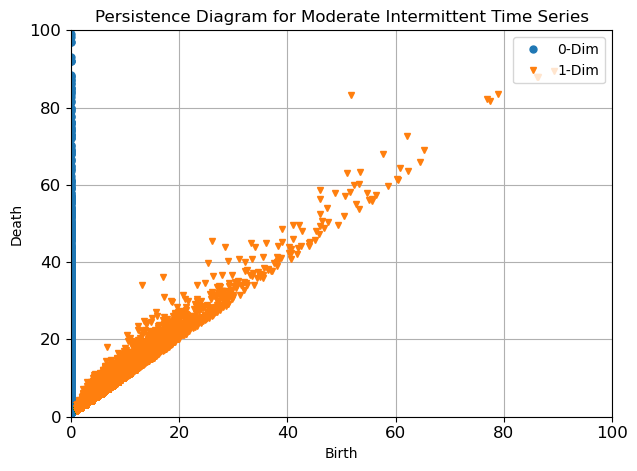

In [23]:
plt.plot(low_fit_df[low_fit_df['dimension'] == 0]['birth'],
         low_fit_df[low_fit_df['dimension'] == 0]['death'], 
         marker='o', markersize=5, linestyle='None')
plt.plot(low_fit_df[low_fit_df['dimension'] == 1]['birth'],
         low_fit_df[low_fit_df['dimension'] == 1]['death'], 
         marker='v', markersize=5, linestyle='None')
plt.title('Persistence Diagram for Moderate Intermittent Time Series')
plt.xlabel('Birth')
plt.ylabel('Death')
plt.xlim(0, 100)
plt.ylim(0, 100)
legend = plt.legend(['0-Dim', '1-Dim'], loc='upper right')
plt.tight_layout()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()

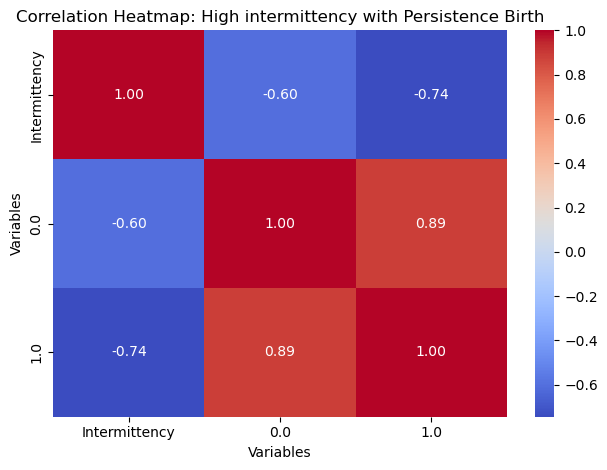

In [24]:
# Correlate intermittency with persistence birth
corr = agg_df_low[['Intermittency', 0, 1]].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap: High intermittency with Persistence Birth')
plt.tight_layout()
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.show()

# Overall

In [25]:
# Combin high, mod and low intermittency
agg_df_high['Group'] = 'High'
agg_df_mod['Group'] = 'Medium'
agg_df_low['Group'] = 'Low'
agg_df = pd.concat([agg_df_high, agg_df_mod, agg_df_low], ignore_index=True)
agg_df = agg_df[['Group', 'Intermittency', 0, 1]]
agg_df.columns = ['Group', 'Intermittency', '0-Dim Birth', '1-Dim Birth']
agg_df.head()

,Group,Intermittency,0-Dim Birth,1-Dim Birth
0,High,0.847525,11,3
1,High,0.912871,24,8
2,High,0.992079,2,1
3,High,0.994059,2,1
4,High,0.976238,4,1


/var/folders/tz/gs_7p8rj7tz_vx4snsdf_c2m0000gp/T/ipykernel_998/438132740.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




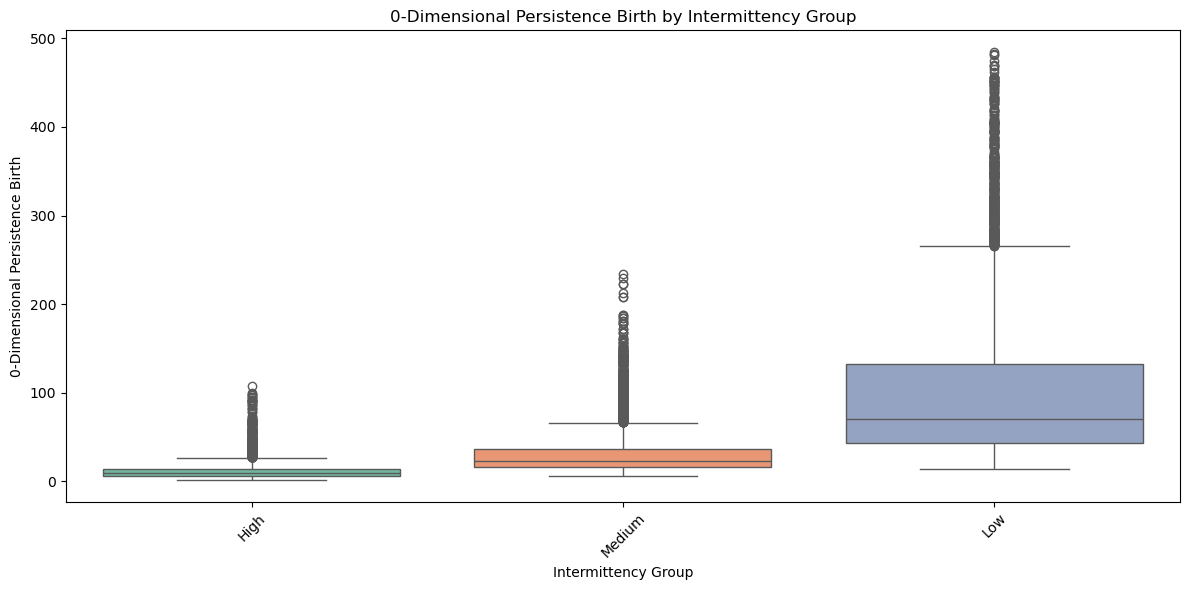

In [26]:
# Plot the aggregated data
plt.figure(figsize=(12, 6))
sns.boxplot(x='Group', y='0-Dim Birth', data=agg_df, palette='Set2')
plt.title('0-Dimensional Persistence Birth by Intermittency Group')
plt.xlabel('Intermittency Group')
plt.ylabel('0-Dimensional Persistence Birth')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/tz/gs_7p8rj7tz_vx4snsdf_c2m0000gp/T/ipykernel_998/3161475167.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




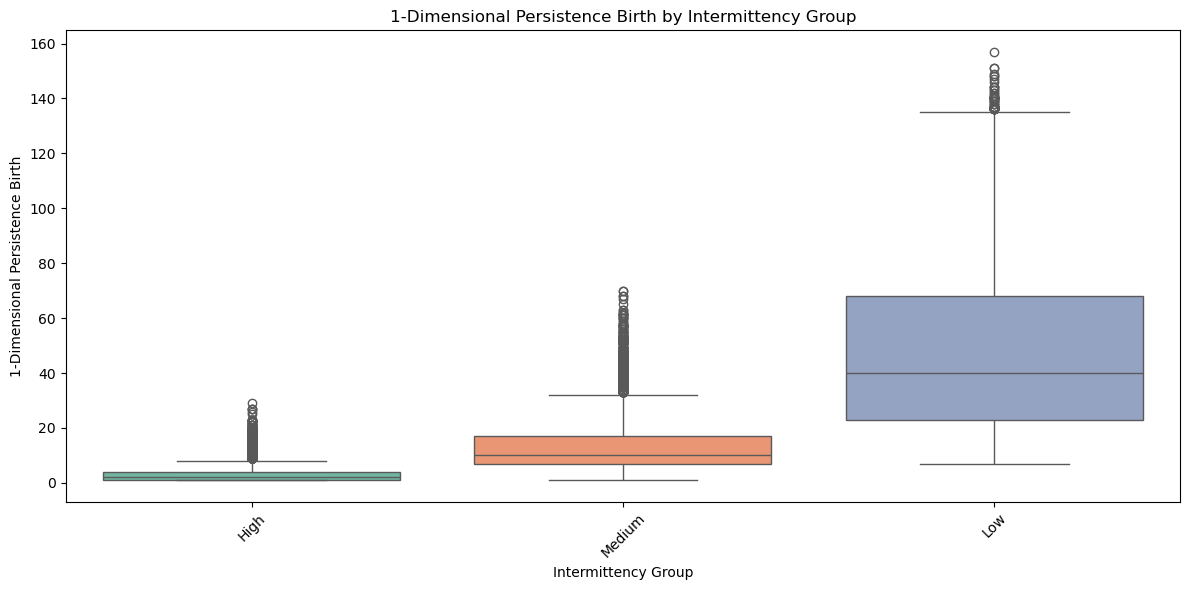

In [27]:
# Plot the aggregated data
plt.figure(figsize=(12, 6))
sns.boxplot(x='Group', y='1-Dim Birth', data=agg_df, palette='Set2')
plt.title('1-Dimensional Persistence Birth by Intermittency Group')
plt.xlabel('Intermittency Group')
plt.ylabel('1-Dimensional Persistence Birth')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

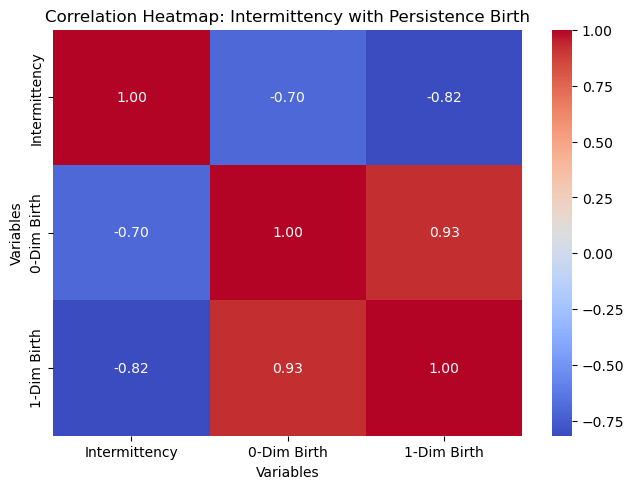

In [28]:
# Correlate intermittency with persistence birth
corr = agg_df[['Intermittency', '0-Dim Birth', '1-Dim Birth']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap: Intermittency with Persistence Birth')
plt.tight_layout()
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.show()

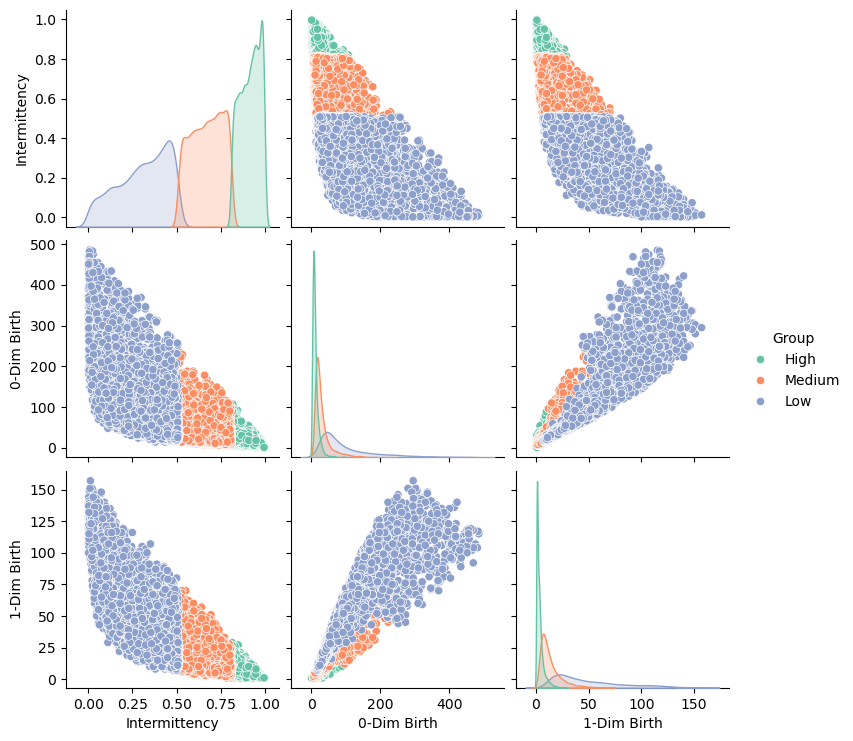

In [29]:
# Pairplot
sns.pairplot(agg_df, hue='Group', vars=['Intermittency', '0-Dim Birth', '1-Dim Birth'], palette='Set2')
plt.show()